In [40]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
import numpy as np
import math
from scipy.stats import pearsonr
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

unis    = pd.read_csv('../Education/data/hd2020.csv', encoding='cp1252')
fnames  = glob('../Education/data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
dfs     = []

for fname in tqdm(fnames): 

    year = int(fname.split('/')[-1].split('_')[0][1:])
    if year <= 2001:
        continue 

    df          = pd.read_csv(fname, index_col=0)
    df          = df.rename(columns={col: col.upper().strip() for col in df.columns})
    df          = df[df['AWLEVEL'].apply(lambda x: x in [5, 7, 9, 17, 18, 19])]
    df['year']  = year
    df['cs']    = df['CIPCODE'].apply(lambda x: (x>=11) & (x<12))
    df['cs2']   = df['CIPCODE']==11.0701
    df['ugd']   = df['AWLEVEL'] == 5
    df['mst']   = df['AWLEVEL'] == 7
    df['phd']   = df['AWLEVEL'] >  7

    dfs.append(df)

100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


In [41]:
all_dfs                     = pd.concat(dfs)
all_dfs['whitemen_abs']     = all_dfs[['CWHITM', 'CRACE11']].max(axis=1)
all_dfs['women_abs']        = all_dfs[['CTOTALW', 'CRACE16']].max(axis=1)
all_dfs['black_abs']        = all_dfs[['CBKAAT', 'CRACE18', 'DVCBKT']].max(axis=1)
all_dfs['black_men_abs']    = all_dfs[['CBKAAM', 'CRACE03', 'DVCBKM']].max(axis=1) 
all_dfs['black_women_abs']  = all_dfs[['CBKAAW', 'CRACE04', 'DVCBKW']].max(axis=1) 
all_dfs['hisp_abs']         = all_dfs[['CRACE21', 'CHISPT','DVCHST']].max(axis=1)
all_dfs['hisp_men_abs']     = all_dfs[['CRACE09', 'CHISPM','DVCHSM']].max(axis=1)
all_dfs['hisp_women_abs']   = all_dfs[['CRACE10', 'CHISPW','DVCHSW']].max(axis=1)
all_dfs['native_abs']       = all_dfs[['CAIANT', 'CRACE19']].max(axis=1)
all_dfs['total_abs']        = all_dfs[['CRACE24', 'CTOTALT']].max(axis=1)

# aggregated = all_dfs.groupby(['year', 'cs', 'ugd']).sum().reset_index()

all_dfs = all_dfs.reset_index()

In [44]:

ugds_cs = all_dfs[(all_dfs['ugd']) & (all_dfs['cs'])]

ugds_cs['women_pct'] = 100*(ugds_cs['women_abs'] / ugds_cs['total_abs']).round(3)
ugds_cs['black_pct'] = 100*(ugds_cs['black_abs'] / ugds_cs['total_abs']).round(3)
ugds_cs['hisp_pct']  = 100*(ugds_cs['hisp_abs']  / ugds_cs['total_abs']).round(3)

ugds_cs['black_women_pct'] = 100*(ugds_cs['black_women_abs'] / ugds_cs['total_abs']).round(3)
ugds_cs['black_men_pct']   = 100*(ugds_cs['black_men_abs']   / ugds_cs['total_abs']).round(3)
ugds_cs['hisp_men_pct']    = 100*(ugds_cs['hisp_men_abs']    / ugds_cs['total_abs']).round(3)
ugds_cs['hisp_women_pct']  = 100*(ugds_cs['hisp_women_abs']  / ugds_cs['total_abs']).round(3)


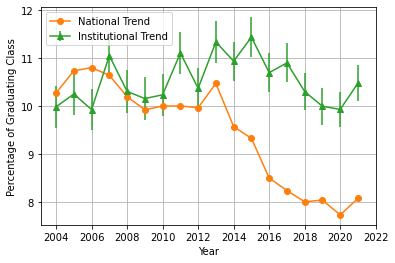

In [56]:
# ugds_cs['black_pct'] = ugds_cs['black_abs'] / ugds_cs['total_abs']
# ugds.index = ugds['year']

national_trend = ugds_cs.groupby('year').apply(lambda x: 100*x['black_abs'].sum() / x['total_abs'].sum())
avg_inst_trend = ugds_cs.groupby('year').apply(lambda x: pd.Series({'mean':x['black_pct'].mean(), 'sem': x['black_pct'].sem()})).reset_index()

# ugds_cs = ugds_cs.reset_index()
# inst_stats_old = all_dfs.groupby(['year', 'cs']).apply(lambda x: pd.Series({'mean':x['black_pct'].mean(), 'sem': x['black_pct'].sem()})).reset_index()

# a = inst_stats[inst_stats['cs']]
plt.errorbar(avg_inst_trend['year'], avg_inst_trend['mean'], yerr=avg_inst_trend['sem'],marker='^', color='#2ca02c', label='Institutional Trend')
# plt.twinx();
plt.plot(national_trend, color='#ff7f0e', marker='o', label='National Trend')

plt.xticks(range(2004, 2023, 2))

# pearsonr(range(len(inst_stats['year'])), inst_stats['mean'])

plt.grid()
plt.xlabel('Year');
plt.ylabel('Percentage of Graduating Class');

plt.legend();

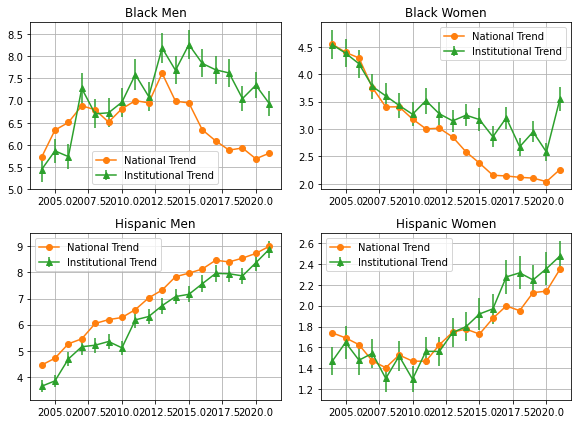

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))#, sharey=True)

axs = axs.flatten()

for i, (label, demo) in enumerate([('Black Men', 'black_men'), ('Black Women', 'black_women'), ('Hispanic Men', 'hisp_men'), ('Hispanic Women', 'hisp_women')]):

    national_trend = ugds_cs.groupby('year').apply(lambda x: 100*x['%s_abs' % demo].sum() / x['total_abs'].sum())
    avg_inst_trend = ugds_cs.groupby('year').apply(lambda x: pd.Series({'mean':x['%s_pct' % demo].mean(), 'sem': x['%s_pct' % demo].sem()})).reset_index()

    axs[i].errorbar(avg_inst_trend['year'], avg_inst_trend['mean'], yerr=avg_inst_trend['sem'], marker='^', color='#2ca02c', label='Institutional Trend')
    axs[i].plot(national_trend, marker='o', label='National Trend', color='#ff7f0e')
    axs[i].set_title(label)

    axs[i].grid()
    axs[i].legend();

plt.tight_layout()